### Model was developed to vertically distributed water storage from a conceptual soil reservoir in a soil column
#### Clap-Hornberger soil moisture function was used
#### Soil properties and storage soil are needed (inputs)

##### @Authors Ahmad Jan (ahmad.jan@noaa.gov) and Fred Ogden

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter 
import sys, os
import imageio, re
import importlib as imp
import matplotlib.image as mpimg
import copy
import pandas as pd

(-0.5, 4444.5, 2414.5, -0.5)

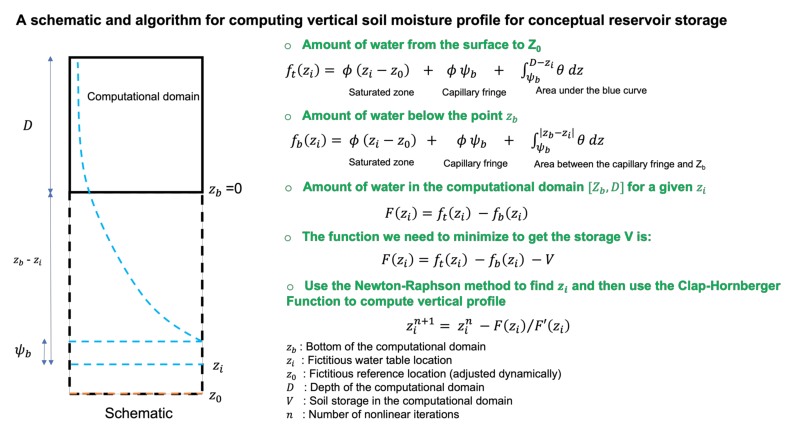

In [28]:
# Upload a schematic here
fig, axs = plt.subplots(1,1,figsize=(14,14))
im_path = mpimg.imread("../data/images/smp_schematic.png")
axs.imshow(im_path)
axs.axis("off")

In [3]:
#test values
D=200 # soil column depth
hb = 35.5  # bubbing/air entry pressure [cm]
lam = 0.190476 # pore distribution index
phi=  0.439 # soil porosity
Vmax = phi * D # maximum soil storage
zb = 0   # bottom of the column
zi = 0   # water table location
z0 = zi - hb # bottom of the fictitious column
thetar = 0 # residual water content, not used for Clap-Hornberger function


In [4]:
beta=1.0-lam;
alpha=pow(hb,lam)/beta;
tol=0.000001;

In [5]:
V1 = 80 # Initial storage in the column
Vinit=V1;
V2=V1;  #/* start-up condition before adding any water */
print ('Init mass = ', V1)

print ("Vmax =", Vmax)
print ("guess for the init water table loc =", z0)


Init mass =  80
Vmax = 87.8
guess for the init water table loc = -35.5


In [32]:
print ('Initial mass', round(V1,4), round(z0,4))
Vinit=V1;
V2=V1;  #/* start-up condition before adding any water */
Theta_ = []
Theta_n = []

Z = []
mass_added_removed = [0,40.0, -47.0]
V2_before = V1

for i in range(2):
    z0 = 0
    zi= z0 + 0.01
    theta_temp = []
    Z_temp = []
    V2_before = V2
    
    V2 = V2 - mass_added_removed[i]
    
    count=0;
    print ("V2: ", V2)
    if(V2>Vmax):
        print ('Max. achieved')
        print("Cell saturated, program terminated after %d loops \n", i)
        break
    
    count = 0
    flag = True
    
    while (flag):
        count = count + 1
        if(count>30):
            flag_nc = True
            print("no convergence loop count: after 15000 iterations: ",i , count, abs(diff), zi)
            break
        f= 0
        df_dz2 = 0
        
        fis = phi * (zi - z0) + phi * hb + alpha*(phi-thetar)* ( pow((D-zi),beta) - pow(hb,beta) )
        fib = phi * (zi - z0) + phi * hb + alpha*(phi-thetar)* ( pow(abs(zb-zi),beta) - pow(hb,beta) )
        
        if zi >=0:
            fib = 0
        f = fis - fib - V2
        
        #print (count, "zi = ", round(zi,8), "f= ",round(f,10), "fis-fib = ",round(fis - fib,8), "fis=",round(fis,8), 
        #       "fib=", round(fib,8), "z0=", round(z0,8), "parts: ", round(phi * (zi - z0),4) , 
        #       round(alpha*(phi-thetar)*pow((D-zi),beta),4))
        
        dfis = phi - alpha*(phi-thetar)* beta * pow((D-zi),beta-1.0)
        dfib = phi - alpha*(phi-thetar)* beta * pow(abs(zb-zi),beta-1.0)
        
        
         
        if zi >=0:
            dfib = 0.0
        df_dzi = dfis - dfib
        # Newton-Raphson scheme
        zi_new=zi-f/df_dzi*1.0
        diff=zi_new-zi
        zi=zi_new
        z0 = zi - hb
        
        if zi >=0:
            z0 = zb
        
        if zi_new > D:
            print ("water table can't exceed surface level", zi_new, D)
            break
        if (abs(diff)<tol):
            print('\nConverged:\n',"Iteration =", count, ", New WT: ", round(zi,4))#, ", OWT: ", round(z1,4), ", diff: ", round(z1 - z2,4))
            flag = False
            break
    
    #hb_= zi - z0
    z=zi +hb
    z11=hb
    print ("Mass before = ", round(V2_before,4), "\nMass after = ", round(V2,4))
    
    #dv = (D-z1-hb)/1000
    LL = 1000
    
    dv = (D-zi)/LL
    for j in range(LL):
        z = z + (D-zi -hb)/LL
        z11 = z11 + (D-zi -hb) /LL #(D-zi-hb*0)/LL
        
        theta= phi * pow((hb/z11),lam) # valid for h > hb
        if theta > phi:
            theta = phi
        theta_temp.append(theta)
        Z_temp.append(round(z,4))
        #print (round(z,4), round(theta,4))
    # store moisture profile for this iteration
    Theta_.append(theta_temp)
    Z.append(Z_temp)

    Zres = np.arange(0.1,2.1,0.1)
    #Zres = np.arange(1,201,1)
    #Zres = [D - 100*i for i in Zres]
    L = len(Zres)
    
    #****************************************
    # Mapping to discretized soil column
    theta_temp1 = []
    Ztemp3 = []
    for i in range(L):
        theta = 0
        for j in range(LL):
            
            if D - Zres[i]*100 <= zi+hb:# and Zres[L-2-i] <= z1 +hb :
                theta = phi
                #print ("A= ",i, j, theta, Z_temp[j], Zres[i], D-Zres[i], zi+hb, theta)
                Ztemp3.append(D-Zres[i]*100)
                break
            elif ( Z_temp[j] >= D-Zres[i]*100):# and Z_temp[j+1] >= Zres[i]):
                theta = round(theta_temp[j],8) 
                #print ("B= ",i, j, theta, Z_temp[j],Z_temp[j-1],  D-Zres[i]*100)#, round(zi+hb,4), theta)
                Ztemp3.append(Z_temp[j])
                break
        
        theta_temp1.append(theta)
    
    Theta_n.append(theta_temp1)
       
    integ1 = np.trapz(Theta_n[-1],x=Zres)
    
    #print (theta_temp)
    print ("Mass in top 2 m = ",  round(integ1*100,4), "Error=", round(integ1*100,4) - V2)
    print ("NOTE: the error is due to numerical integration, higher resolution decreases the error!")
    

Initial mass 80 -2138.1177
V2:  80

Converged:
 Iteration = 4 , New WT:  49.0438
Mass before =  80 
Mass after =  80
Mass in top 2 m =  76.6272 Error= -3.372799999999998
NOTE: the error is due to numerical integration, higher resolution decreases the error!
V2:  40.0

Converged:
 Iteration = 8 , New WT:  -2102.6177
Mass before =  80 
Mass after =  40.0
Mass in top 2 m =  38.0123 Error= -1.9876999999999967
NOTE: the error is due to numerical integration, higher resolution decreases the error!


In [22]:
print (Ztemp3)
print (Zres[::-1]*100)

[190.0086, 180.0172, 170.0, 160.0, 150.0, 140.0, 130.0, 120.0, 110.0, 100.0, 89.99999999999999, 79.99999999999999, 69.99999999999997, 60.0, 49.99999999999997, 40.0, 29.99999999999997, 19.99999999999997, 10.0, 0.0]
[200. 190. 180. 170. 160. 150. 140. 130. 120. 110. 100.  90.  80.  70.
  60.  50.  40.  30.  20.  10.]


Initial mass [cm]      =  80
Mass added/removed [cm]      =  -7.0
Final mass [cm]        =  87.0
Area under red curve   =  12.2412
Area under green curve =  0.8303


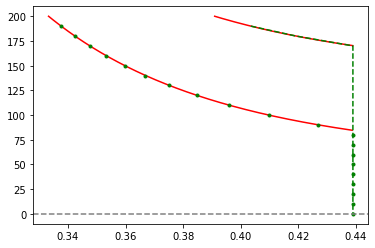

In [23]:
ZresN = [i*100 - Zres[0]*100 for i in Zres[::-1]] 
# removed Zres[0] for plotting only; Zres and Ztemp3 are not matching for coarse resolutio; using high resolution solves the issue
# but computational domain for soil moisture profiles (C++) has coarse discretization

plt.plot(Theta_[0],Z[0], "r")#,marker='p',markersize=4)
plt.plot(Theta_n[0],ZresN, "g.")#,linestyle='dashed')

#plt.plot(Theta_[1],Z[1], "r")
#plt.plot(Theta_n[1],ZresN, "b",linestyle='dashed')

plt.plot(Theta_[-1],Z[-1], "r")
plt.plot(Theta_n[-1],ZresN, "g",linestyle='dashed')

plt.axhline(y=0,color='grey',linestyle='dashed')

integWT = np.trapz(Theta_[-1],x=Z[-1])
integ2m = np.trapz(Theta_n[-1],x=Zres)

print ("Initial mass [cm]      = ", round(Vinit,4))
print ("Mass added/removed [cm]      = ",sum(mass_added_removed))
print ("Final mass [cm]        = ", round(V2,4))
print ("Area under red curve   = ", round(integWT,4))
print ("Area under green curve = ", round(integ2m,4))